# Projekt 2
#### Bartosz Eljasiak, Mateusz Grzyb, Mariusz Słapek

## Wczytanie pakietów

In [171]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

## Wczytanie danych

In [172]:
raw_data = pd.read_csv('../data/online_shoppers_intention.csv')

raw_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


## Inżynieria cech

### Skalowanie zmiennych numerycznych

Wszystkie zmienne numeryczne, oprócz zmiennej 'SpecialDay', a zatem zmienne 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates' i 'PageValues' poddamy skalowaniu. Zakres wartości zmiennej 'SpecialDay' już wynosi [0, 1], więc nie jest to dla niej konieczne.

Użyjemy transformacji MinMaxScaler, ponieważ ujemne wartości cech (jakie wprowadziłby np. StandardScaler) wydają się nie mieć tutaj sensu.

In [173]:
data = raw_data.copy()
variables = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
scaler = MinMaxScaler()

data[variables] = scaler.fit_transform(data[variables])

Zakres wartości wspomnianych cech zmienił się odpowiednio, co widoczne jest na poniższych wykresach.

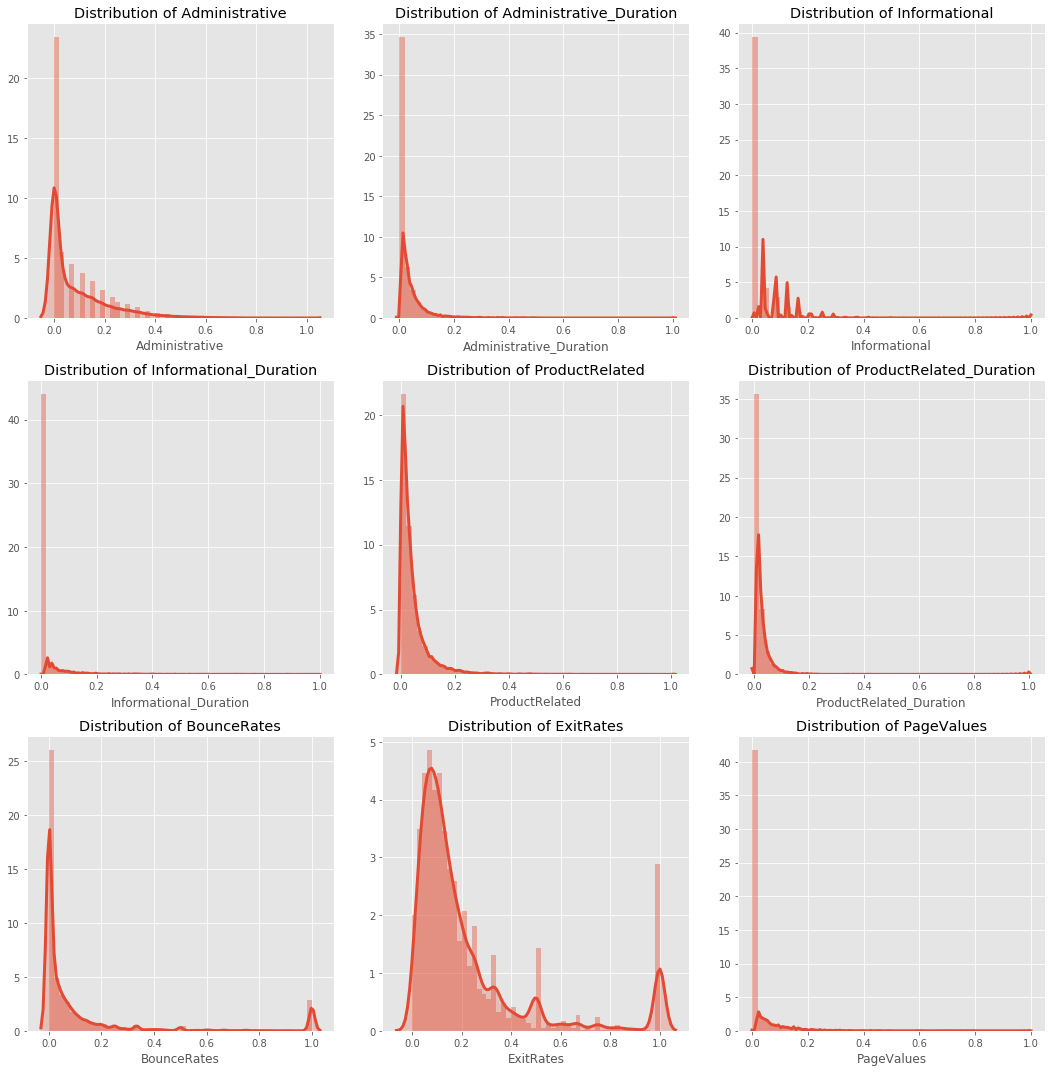

In [174]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0, len(variables)):
    sns.distplot(data[variables[i]].dropna(), hist=True, kde=True, kde_kws={'shade': True, 'linewidth': 3},
                 ax=axes[i//3, i%3]).set_title('Distribution of %s' % (variables[i]))

plt.tight_layout();

### Kodowanie zmiennej 'Month'

Zmienną 'Month' zakodujemy w postaci kolejnych wierzchołków dwunastokąta foremnego, wpisanego w okrąg jednostkowy. W tym celu stworzymy dwie zmienne Month_x i Month_y, obie o zakresie wartości [-1, 1]. W ten sposób porządek między kolejnymi miesiącami zostanie zachowany (kąt), ale odległość między np. grudniem i styczniem będzie taka sama, jak między styczniem a lutym.

In [175]:
# najpierw kodowanie na int
month_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data['Month'] = data['Month'].replace(month_to_int)

# nastepnie na okregu
data['Month_x']=data['Month'].transform(lambda x: np.sin((np.pi/6)*x))
data['Month_y']=data['Month'].transform(lambda x: np.cos((np.pi/6)*x))

Sprawdźmy jeszcze wizualnie poprawność metody.

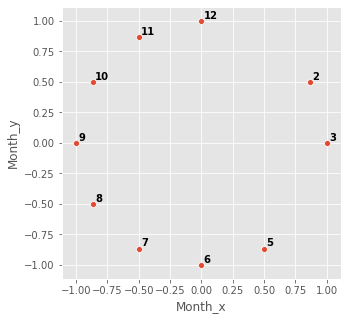

In [176]:
plot_data = data[['Month_x', 'Month_y', 'Month']].drop_duplicates().reset_index()
fig, ax = plt.subplots(figsize=(5, 5)) 
ax = sns.scatterplot('Month_x', 'Month_y', data=plot_data)

for i in range(0, plot_data.shape[0]):
    ax.text(plot_data.loc[i, 'Month_x']+0.02, plot_data.loc[i, 'Month_y']+0.02, 
    plot_data.loc[i, 'Month'], horizontalalignment='left', 
    size='medium', color='black', weight='semibold')

Miesiące poprawnie rozłożyły się na okręgu jednostkowym, co jest widoczne na powyższym wykresie. W danych brakuje obserwacji ze stycznia i kwietnia, zgodnie ze wcześniejszą analizą.

In [177]:
data = data.drop('Month', axis=1)

### Kodowanie zmiennych kategorycznych

Zajmiemy się teraz zmiennymi 'OperatingSystems', 'Browser', 'Region', 'TrafficType' i 'VisitorType'. Przyjrzyjmy się ponownie ich rozkładom.

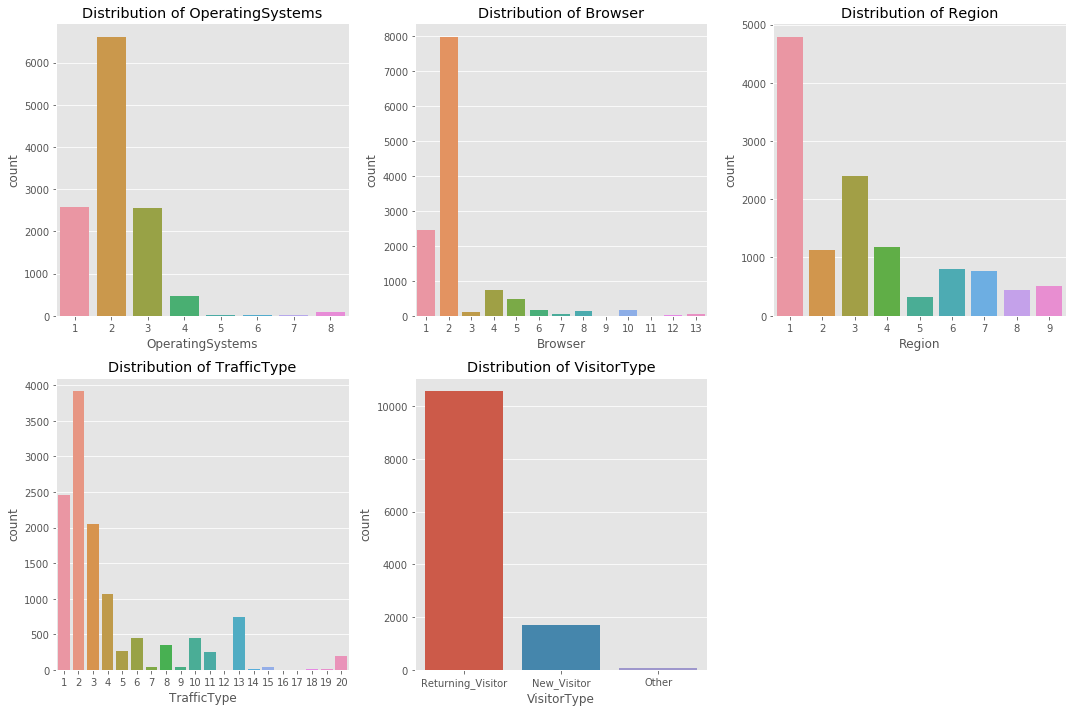

In [178]:
variables = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(0, len(variables)):
    sns.countplot(data=data, x=variables[i], ax=axes[i//3, i%3]).set_title('Distribution of %s' % (variables[i]))
for ax in f.axes:
    ax.set_ylabel('')
    
fig.delaxes(axes.flatten()[5])
plt.tight_layout();

Posłużymy się kodowaniem One-Hot. Zmienna 'VisitorType' ma tylko 3 poziomy i może bezproblemowo zostać zakodowana w całości. Pozostałe zmienne są bardziej rozbudowane i kodowanie ich w całości znacząco zwiększyłoby wymiarowość danych. Z tego powodu zakodujemy tylko 4 najpowszechniejsze kategorie dla każdej ze wspomnianych zmiennych.

In [179]:
# kodowanie zmiennej VisitorType
encoder = OneHotEncoder(sparse=False)
temp = pd.DataFrame(encoder.fit_transform(data[['VisitorType']]))
temp.columns = encoder.get_feature_names(['VisitorType'])
data = pd.concat([data, temp], axis=1)
data = data.drop('VisitorType', axis=1)

# kodowanie pozostalych zmiennych
variables = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

for variable in variables:
    values_to_leave = data[variable].value_counts()[:4].index.tolist()
    data[variable] = data[variable].transform(lambda x: x if (x in values_to_leave) else 'other').astype(str)
    
    encoder = OneHotEncoder(sparse=False)
    temp = pd.DataFrame(encoder.fit_transform(data[[variable]]))
    temp.columns = encoder.get_feature_names([variable])
    data = pd.concat([data, temp], axis=1)
    data = data.drop(variable, axis=1)

Sprawdźmy efekt kodowania.

In [180]:
data.iloc[:, 14:]

,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12326,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Kodowanie zmiennych typu Bool

Zmienne 'Weekend' i 'Revenue' przyjmują wartości 'True' i 'False', co przełożymy na wartości 1 i 0.

In [181]:
variables=  ['Weekend', 'Revenue']

for variable in variables:
    data[variable] = data[variable].transform(lambda x: 1 if x else 0)

Sprawdźmy efekt kodowania.


In [182]:
data[variables]

,Weekend,Revenue
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
12325,1,0
12326,1,0
12327,1,0
12328,0,0


### Efekt końcowy

Po przejściu przez powyższy proces dane prezentują się następująco.

In [183]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_x,Month_y,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other
0,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.002837,0.001000,0.000000,0.500000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.002837,0.000042,0.250000,0.700000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.0,0.0,0.014184,0.009809,0.100000,0.250000,0.000000,0.0,1,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,1,0,-2.449294e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,0,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Wstępne modelowanie

Funkcja _predict dokonuje klasteryzacji danych wybraną metodą i zwraca podział w postaci wektora.

In [184]:
def _predict(data, model):
    model.fit(data)
    if hasattr(model, 'labels_'):
        prediction = model.labels_.astype(np.int)
    else:
        prediction = model.predict(X)
    return prediction

Funkcja grouped_revenue dokonuje klasteryzacji danych (bez zmiennej 'Revenue') wybraną metodą i zwraca wykresy liczności grup oraz odsetków sesji zakończonych przychodem dla każdej grupy.

In [297]:
def grouped_revenue(data, model):
    prediction = _predict(data.drop('Revenue', axis=1), model)
    plotdata = pd.DataFrame({'Group': prediction, 'Revenue': data['Revenue']})
    plotdata = pd.crosstab(plotdata['Group'], plotdata['Revenue'])
    plotdata['Cardinality'] = plotdata[0] + plotdata[1]
    plotdata['Revenue_ratio'] = plotdata[1] / plotdata['Cardinality']
    plotdata = plotdata.reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.barplot(data=plotdata, x='Group', y='Cardinality', ax=axes[0]).set_title('Cluster Cardinality');
    sns.barplot(data=plotdata, x='Group', y='Revenue_ratio', ax=axes[1]).set_title('In-cluster Revenue_ratio');
    
    plt.tight_layout(pad=1)
    
    return fig

Wywołamy teraz funkcję grouped_revenue dla przygotowanych wcześniej danych i modelu AgglomerativeClustering z parametrem linkage='ward' i róznymi wartościami parametru n_clusters (2-10).

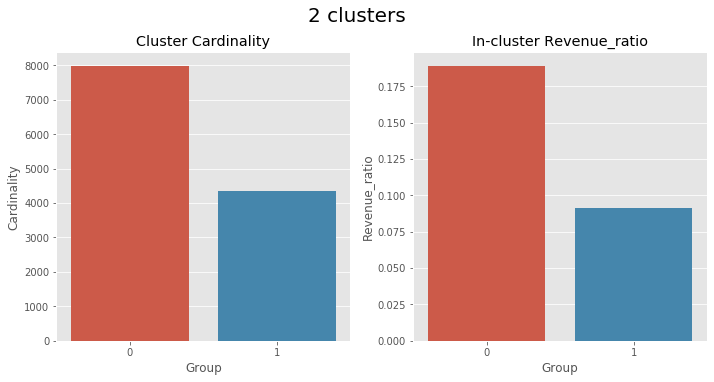

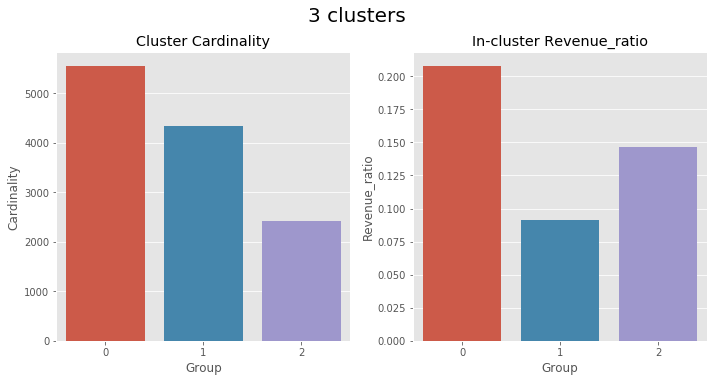

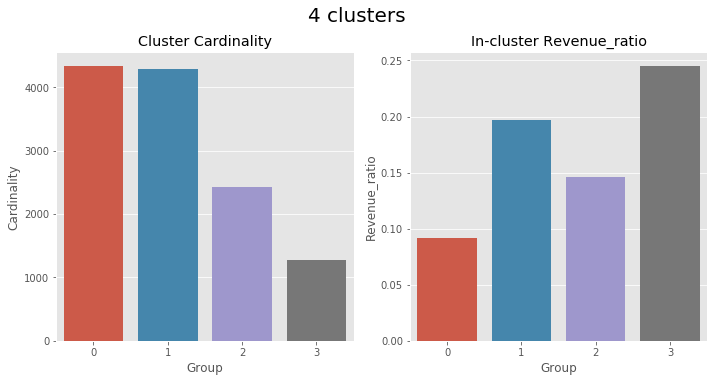

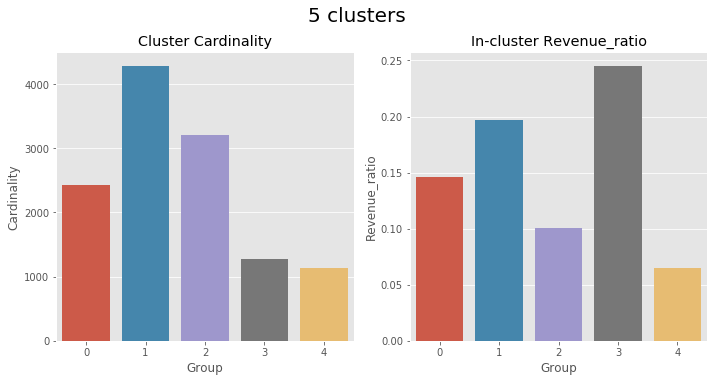

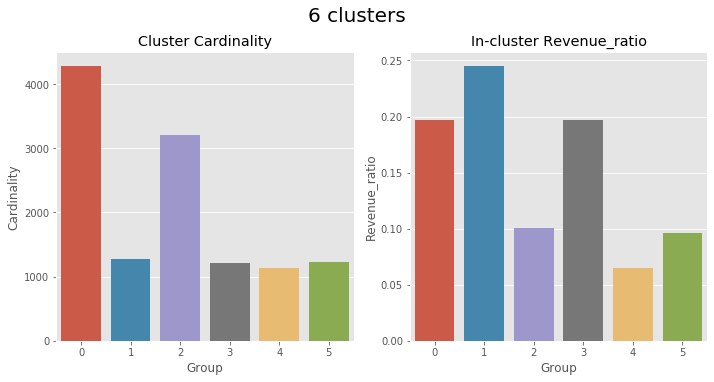

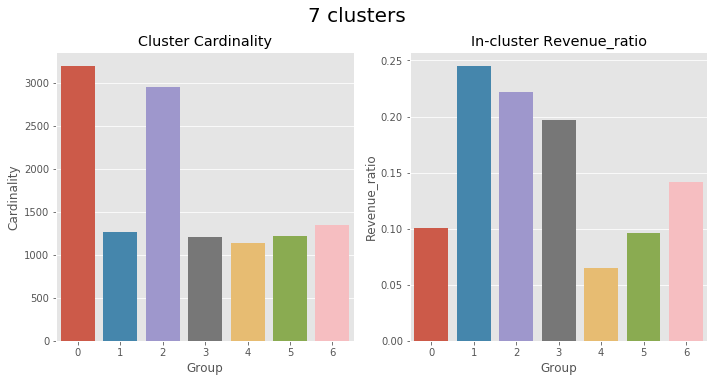

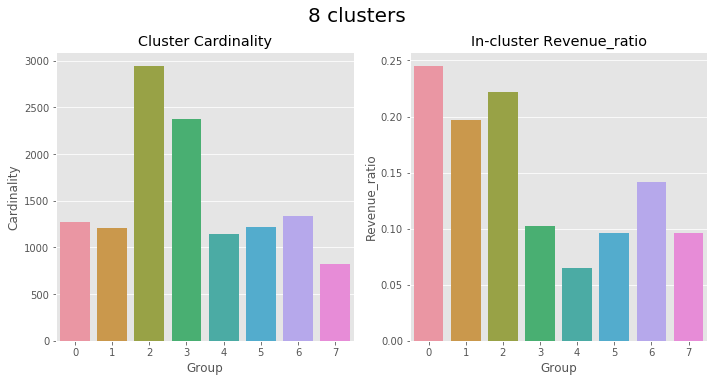

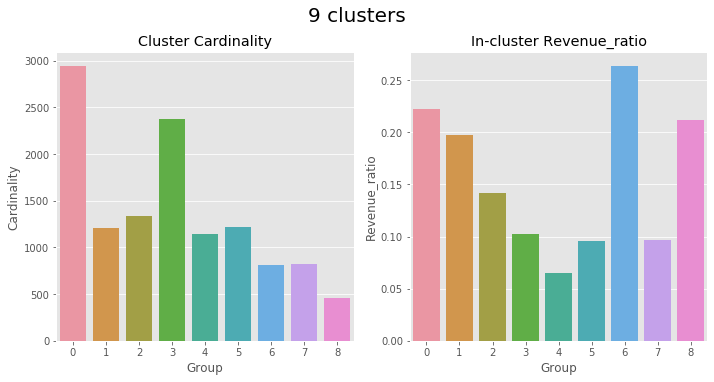

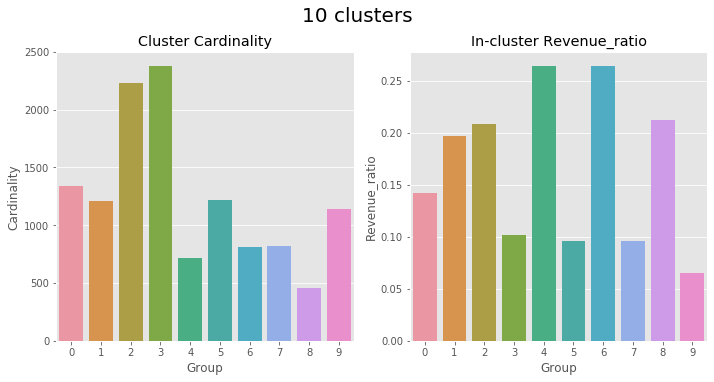

In [298]:
for i in range(2, 11):
    plot = grouped_revenue(data, AgglomerativeClustering(n_clusters=i, linkage='ward'))
    plot.suptitle(str(i)+' clusters', fontsize=20, y=1.05);

Ciekawym wynikiem jest np. ten uzyskany dla parametru n_clusters=6.

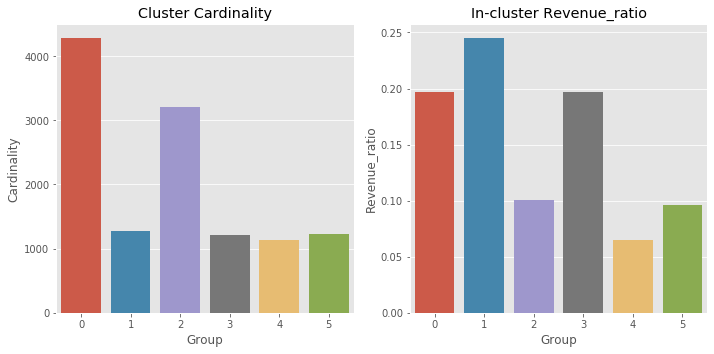

In [187]:
plot = grouped_revenue(data, AgglomerativeClustering(n_clusters=6, linkage='ward'))
plt.close()
plot

Mamy tutaj 3 grupy o Revenue_ratio <= 0.10 i 3 grupy o Revenue_ratio >= 0.20, a zatem conajmniej dwukrotnie większym. Wszystkie grupy zawierają co najmniej 1000 obserwacji.

Spróbujemy teraz zidentyfikować znaczące czynniki, z punktu widzenia powyższego podziału.

W tym celu, przygotujemy model XGBoost do przewidywania zmiennej 'Revenue', a następnie odczytamy uzyskany w ten sposób Feature Importance (typu 'gain'). Następnie, porównamy rozkłady uzyskanych w ten sposób najważniejszych cech między grupami.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Revenue', axis=1), data['Revenue'], test_size=0.25, stratify=data['Revenue'])
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Classification report:\n%s" %(classification_report(y_test, y_pred)))
print("AUC score: %.2f" % (roc_auc_score(y_test, y_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2606
           1       0.69      0.57      0.62       477

    accuracy                           0.89      3083
   macro avg       0.81      0.76      0.78      3083
weighted avg       0.89      0.89      0.89      3083

AUC score: 0.76


Wyniki modelu nie są idealne, ale w przypadku naszego zastosowania w zupełności wystarczające. Nie ma potrzeby np. strojenia hiperparametrów. Sprawdźmy, jakie Feature Importance uzyskaliśmy.

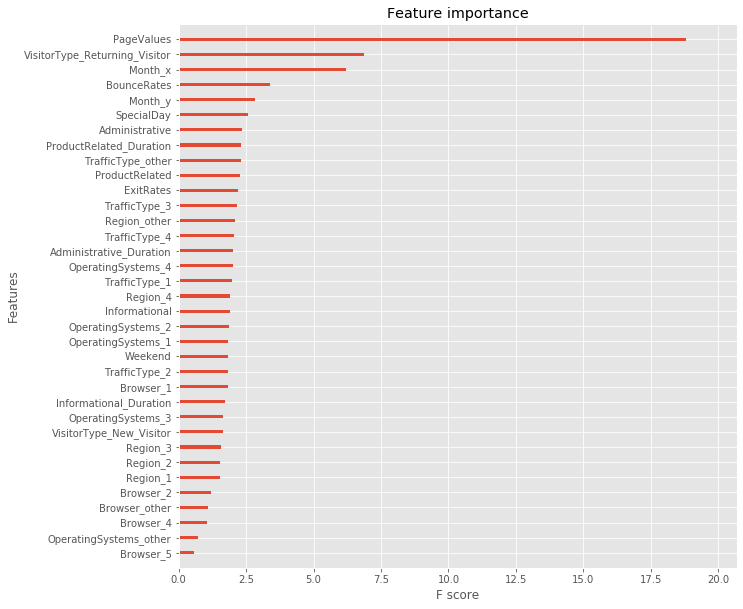

In [189]:
fig, ax = plt.subplots(figsize=(10, 10))  
with plt.style.context('ggplot'):
    plot_importance(xgb, ax=ax, importance_type='gain', show_values=False);

Porównamy rozkłady kilku najważniejszych cech (odczytanych z powyższego wykresu) między grupami. Na czerwono zaznaczono grupy o wysokim Revenue_ratio.

In [190]:
ac = AgglomerativeClustering(n_clusters=6, linkage='ward')
pred = pd.Series(_predict(data.drop('Revenue', axis=1), ac), name='group')
grouped_data = pd.concat([data, pred], axis=1)

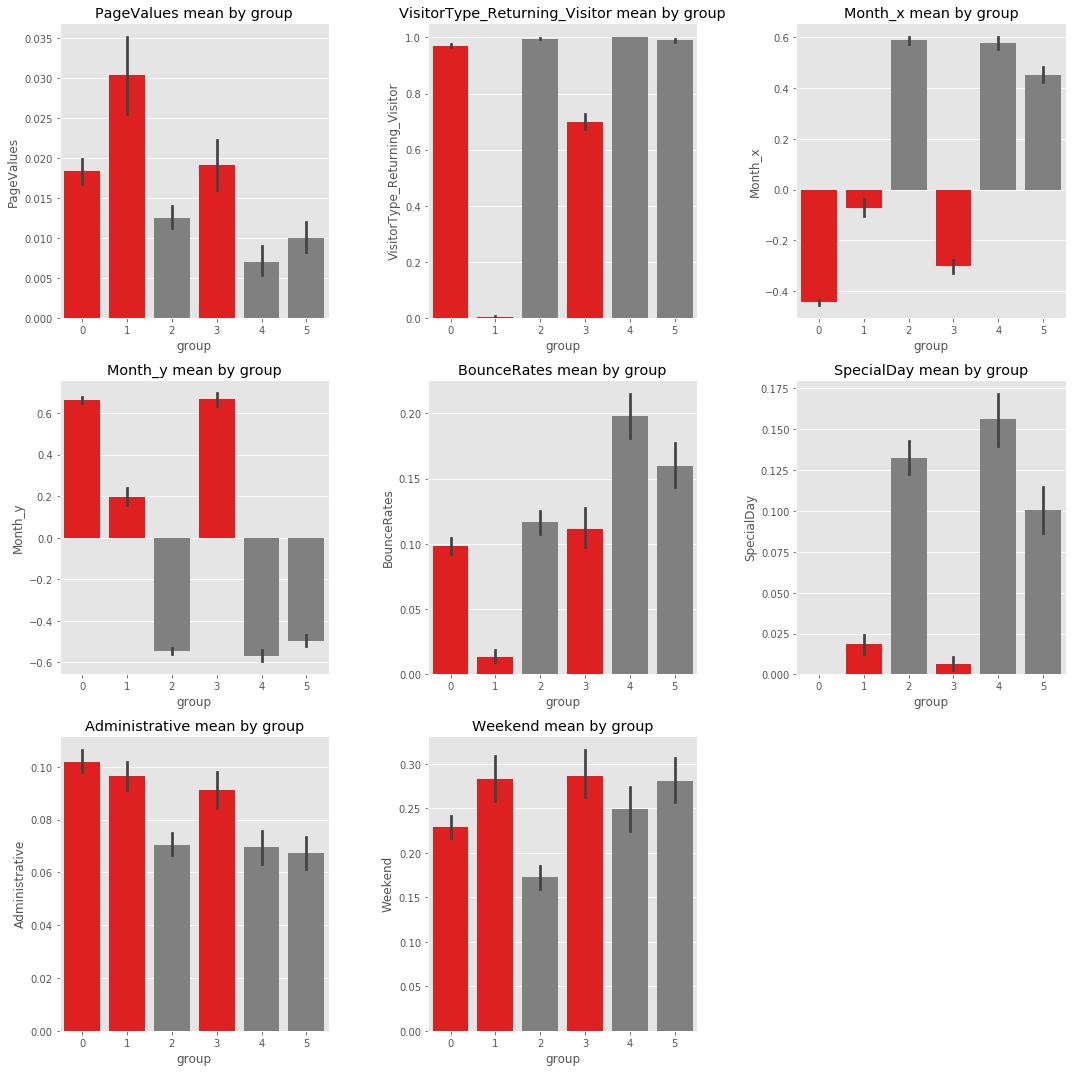

In [194]:
# wezmy jeszcze weekend z racji wczesniejszej analizy tego zagadnienia (na etapie EDA)
variables=['PageValues', 'VisitorType_Returning_Visitor', 'Month_x', 'Month_y', 'BounceRates', 'SpecialDay', 'Administrative', 'Weekend']
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0, len(variables)):
    sns.barplot(x='group', y=variables[i], data=grouped_data, estimator=np.mean, palette=['red', 'red', 'grey', 'red', 'grey', 'grey'],
                ax=axes[i//3, i%3]).set_title('%s mean by group' % (variables[i]))

fig.delaxes(axes.flatten()[8])
plt.tight_layout()

Z powyższych wykresów obserwujemy, że:
    
* dla grup o wyższym Revenue_ratio średnie PageValues jest zauważalnie wyższe,
* sesje nowych użytkowników zawierają się niemal wyłącznie w grupach o wyższym Revenue_ratio (grupa 1 to niemal same tego typu sesje),
* dla grup o wyższym Revenue_ratio średnie Month_x jest ujemne, a średnie Month_y dodatnie, a dla grup o niższym Revenue_ratio jest dokładnie odwrotnie,
* dla grup o wyższym Revenue_ratio średnie BounceRates jest niższe (szczególnie niskie jest dla grupy 1),
* zaskakująco, sesje z grup o wyższym Revenue_ratio, są znacznie oddalone od dni specjalnych (co jest zgodne ze wcześniejszą analizą),
* sesje z grup o wyższym Revenue_ratio zawierają średnio większą liczbę odwiedzonych stron administracyjnych,
* wśród sesji z grup o wyższym Revenue_ratio większy ich odsetek dotyczy weekendu (co jest zgodne ze wcześniejszą analizą).

Zestawimy jeszcze stwierdzenie 
> dla grup o wyższym Revenue_ratio średnie Month_x jest ujemne, a średnie Month_y dodatnie, a...

z poniższym wykresem, ilustrującym sposób, w jaki zakodowaliśmy informacje o miesiącach.

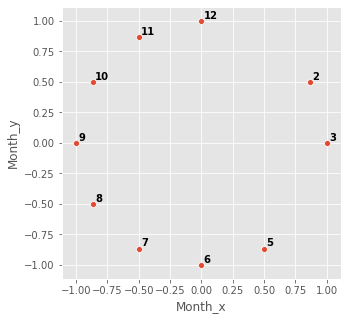

In [192]:
fig, ax = plt.subplots(figsize=(5, 5)) 
ax = sns.scatterplot('Month_x', 'Month_y', data=plot_data)

for i in range(0, plot_data.shape[0]):
    ax.text(plot_data.loc[i, 'Month_x']+0.02, plot_data.loc[i, 'Month_y']+0.02, 
    plot_data.loc[i, 'Month'], horizontalalignment='left', 
    size='medium', color='black', weight='semibold')

Stwierdzenie to oznacza zatem, że sesje te dotyczą przede wszystkim IV kwartału.

### Dodatek
Poniżej znajdują się tabele z statystykami opisowymi wszystkich grup.

In [204]:
for i in range(6):
    display(raw_data[grouped_data['group']==i].describe())

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,4290.000000,4290.000000,4290.000000,4290.00000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,2.751748,94.283665,0.649883,48.02884,44.789510,1714.871590,0.019681,0.039617,6.640945,0.000093,2.402331,2.721212,3.214219,4.443590
std,3.749084,196.240308,1.430941,176.30039,58.757646,2526.951175,0.043703,0.043968,19.197583,0.006107,0.954744,2.015247,2.501300,4.803066
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.00000,10.000000,292.218750,0.000000,0.015152,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000
50%,1.000000,19.000000,0.000000,0.00000,25.000000,896.795139,0.004607,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,110.909167,1.000000,0.00000,55.000000,2136.460959,0.015741,0.043117,1.620495,0.000000,3.000000,2.000000,4.000000,6.000000
max,27.000000,3398.750000,14.000000,2549.37500,686.000000,63973.522230,0.200000,0.200000,360.953384,0.400000,8.000000,13.000000,9.000000,20.000000


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,2.608183,89.315292,0.354839,22.794436,19.638867,678.773276,0.002697,0.018006,10.985703,0.018568,2.281668,2.515342,3.424862,3.751377
std,2.617457,157.774105,0.983713,97.815205,19.821710,811.415873,0.015366,0.021245,30.650368,0.108395,0.753555,1.413504,2.620118,3.121104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.762500,0.000000,0.006250,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,2.000000,47.000000,0.000000,0.000000,14.000000,445.000000,0.000000,0.012500,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,108.250000,0.000000,0.000000,25.000000,892.500000,0.000000,0.022222,0.000000,0.000000,2.000000,2.000000,6.000000,5.000000
max,15.000000,1946.000000,10.000000,1779.166667,287.000000,12983.787710,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,1.902218,64.287362,0.423930,31.229352,28.611684,1105.386274,0.023333,0.048262,4.530944,0.132459,2.044986,2.864730,3.147766,3.750703
std,3.173346,172.798430,1.241437,134.508890,38.390674,1749.164414,0.050397,0.050341,13.920118,0.273723,0.373130,1.699304,2.301162,3.484118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,158.333333,0.000000,0.016394,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,17.000000,581.226191,0.003175,0.030435,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000
75%,3.000000,56.400000,0.000000,0.000000,36.000000,1425.183333,0.018182,0.057143,0.000000,0.000000,2.000000,4.000000,4.000000,4.000000
max,24.000000,2629.253968,24.000000,2050.433333,705.000000,43171.233380,0.200000,0.200000,239.980000,1.000000,8.000000,13.000000,9.000000,20.000000


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000
mean,2.464404,96.134353,0.549669,31.987999,26.000828,972.060206,0.022335,0.041455,6.902559,0.006457,1.153146,1.014073,2.947848,3.543874
std,3.252743,175.993792,1.268776,125.613106,34.830528,1474.941662,0.050157,0.049541,19.970805,0.067563,0.726278,0.231634,2.297240,3.150949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,6.000000,158.730000,0.000000,0.013625,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
50%,1.000000,29.933333,0.000000,0.000000,15.000000,517.187500,0.002991,0.024258,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000
75%,4.000000,121.066667,0.000000,0.000000,33.000000,1268.498958,0.015427,0.043085,0.000000,0.000000,1.000000,1.000000,4.000000,3.000000
max,20.000000,1715.000000,10.000000,1657.300000,517.000000,27009.859430,0.200000,0.200000,218.864910,1.000000,8.000000,8.000000,9.000000,20.000000


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000
mean,1.875329,67.698474,0.394205,19.389780,22.314311,771.006828,0.039557,0.059480,2.532617,0.156629,2.951712,2.000878,3.234416,5.171203
std,2.933998,147.607452,1.062213,69.280406,26.684933,1021.206976,0.059802,0.057769,10.554743,0.298763,0.498102,0.175371,2.374145,4.533959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000176,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,5.000000,114.941667,0.000000,0.019392,0.000000,0.000000,3.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,14.000000,409.303030,0.013793,0.035897,0.000000,0.000000,3.000000,2.000000,3.000000,3.000000
75%,3.000000,82.233333,0.000000,0.000000,28.000000,1072.263322,0.047619,0.075000,0.000000,0.200000,3.000000,2.000000,4.000000,7.500000
max,16.000000,2156.166667,9.000000,954.000000,358.000000,9760.690488,0.200000,0.200000,215.009412,1.000000,4.000000,5.000000,9.000000,20.000000


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,1.821458,65.089355,0.409500,24.027517,21.072891,754.245675,0.031971,0.053999,3.632741,0.100901,1.377559,1.243243,2.738739,3.415233
std,2.898145,152.175140,1.128342,110.817729,26.584084,1031.416330,0.059279,0.057190,12.387821,0.248618,1.016642,1.214245,2.113512,2.992131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,5.000000,116.500000,0.000000,0.016000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,13.000000,403.833333,0.005474,0.031389,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000
75%,3.000000,75.846154,0.000000,0.000000,27.000000,960.833333,0.027778,0.066667,0.000000,0.000000,1.000000,1.000000,4.000000,4.000000
max,19.000000,1640.590909,12.000000,2195.300000,310.000000,11492.208380,0.200000,0.200000,165.620467,1.000000,7.000000,10.000000,9.000000,20.000000


Nieudana próba z TSNE.

In [321]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=20, perplexity=45, n_jobs=-1)
transformed = tsne.fit_transform(data)

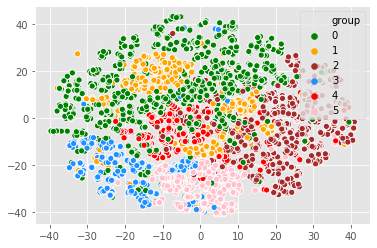

In [322]:
xs = transformed[:, 0]
ys = transformed[:, 1]
sns.scatterplot(xs, ys, hue=pred, palette=['green','orange','brown','dodgerblue','red', 'pink']);